In [6]:
from pathlib import Path
import pandas as pd

In [2]:
data_path = f"data/netflix_movies/"
data_folder_name = "training_set"
file_path = data_path + data_folder_name

In [5]:
i = 0
for file_name in Path(file_path).iterdir():
    print(file_name)
    with open(file_name, 'r') as file:
        movie_id = file.readline()[:-1]
        for line in file:
            user_id, rating, date = line.split(',')
        i += 1
        if i == 10:
            break

data/netflix_movies/training_set/mv_0000373.txt
data/netflix_movies/training_set/mv_0010160.txt
data/netflix_movies/training_set/mv_0009431.txt
data/netflix_movies/training_set/mv_0006702.txt
data/netflix_movies/training_set/mv_0016511.txt
data/netflix_movies/training_set/mv_0015018.txt
data/netflix_movies/training_set/mv_0002564.txt
data/netflix_movies/training_set/mv_0012777.txt
data/netflix_movies/training_set/mv_0004115.txt
data/netflix_movies/training_set/mv_0013469.txt


In [30]:
def read_single_file(file_name: Path):
    users = []
    ratings = []
    dates = []
    with open(file_name, 'r') as f:
        movie_id = f.readline().split(':')[0]
        for line in f:
            user_id, rating, date = line.split(',')
            users.append(user_id)
            ratings.append(rating)
            dates.append(date)
        movie_data = {movie_id: (users, ratings, dates)}
    return movie_data

all_movies, all_users, all_ratings, all_dates = [], [], [], []
i = 0
for file_name in Path(file_path).iterdir():
    if file_name.suffix == '.txt':
        movie_data = read_single_file(file_name)
        movie_id = list(movie_data.keys())[0]
        users, ratings, dates = movie_data[movie_id]
        all_movies.extend([movie_id] * len(users))
        all_users.extend(users)
        all_ratings.extend(ratings)
        all_dates.extend(dates)
        i += 1
data = pd.DataFrame({'movie': list(map(int, all_movies)),
                    'user': list(map(int, all_users)),
                    'rating': list(map(int, all_ratings)),
                    'date': pd.to_datetime(all_dates)})

In [31]:
data = data[['movie', 'user']].groupby('user').count()
data

,movie
user,
6,626
7,881
8,98
10,260
25,27
...,...
2649404,54
2649409,50
2649421,25


In [35]:
data['movie'].median()

96.0

<Axes: >

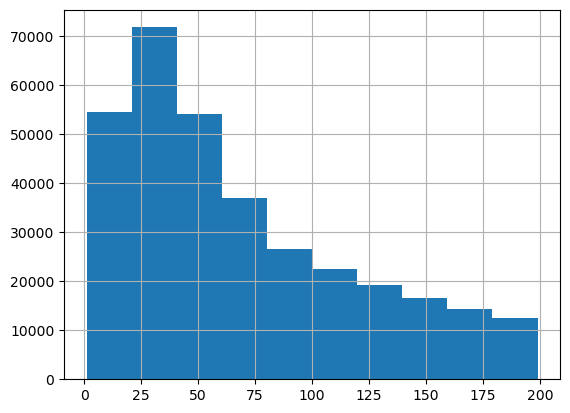

In [34]:
data[data['movie'] < 200]['movie'].hist()

In [24]:
data['is_valid'] = False
data['is_test'] = False
data.loc[
    data.sort_values(['user', 'date']).groupby(['user']).tail(3).index,
    'is_valid'] = True
data.loc[
    data[data['is_valid'] == False].sort_values(['user', 'date']).groupby('user').tail(3).index,
    'is_test'] = True
data = data.drop(columns='date')

In [14]:
from helper_modules.dataset_class import BPRDataset

In [25]:
train_df = data[(data['is_valid'] == False) & (data['is_test'] == False)].reset_index(drop=True).drop(columns=['is_valid', 'is_test'])
valid_df = data[data['is_valid'] == True].reset_index(drop=True).drop(columns=['is_valid', 'is_test'])
test_df = data[data['is_test'] == True].reset_index(drop=True).drop(columns=['is_valid', 'is_test'])

In [26]:
train_df.shape, valid_df.shape, test_df.shape

((4219686, 3), (1187986, 3), (836815, 3))

In [27]:
num_items = data['user'].nunique()
train_user_item_pairs = []
for _, user, item in train_df[train_df['rating'] >= 0][['user', 'movie']].itertuples():
    train_user_item_pairs.append((user, item))
print(f"N train interactions {len(train_user_item_pairs)}")
valid_user_item_pairs = []
for _, user, item in valid_df[valid_df['rating'] >= 0][['user', 'movie']].itertuples():
    valid_user_item_pairs.append((user, item))
print(f"N valid interactions {len(valid_user_item_pairs)}")
test_user_item_pairs = []
for _, user, item in test_df[test_df['rating'] >= 0][['user', 'movie']].itertuples():
    test_user_item_pairs.append((user, item))
print(f"N test interactions {len(test_user_item_pairs)}")

N train interactions 4219686
N valid interactions 1187986
N test interactions 836815


In [28]:
train_dataset = BPRDataset(train_user_item_pairs, num_items)
valid_dataset = BPRDataset(valid_user_item_pairs, num_items)
test_dataset = BPRDataset(test_user_item_pairs, num_items)
train_dataloader = BPRDataset.get_dataloader(train_dataset, 16)
valid_dataloader = BPRDataset.get_dataloader(valid_dataset, 16)
test_dataloader = BPRDataset.get_dataloader(test_dataset, 16)

In [29]:
f"Created dataloaders for train {len(train_dataloader)}, validation {len(valid_dataloader)}, test {len(test_dataloader)}"

'Created dataloaders for train 263731, validation 74250, test 52301'